### ***DÙNG LIGHTNING ĐỂ HUẤN LUYỆN TẬP MNIST***

In [7]:
import torch
from torchvision.datasets import MNIST
from torch import nn
from torchvision.transforms import v2 as T
from torch.utils.data import random_split, DataLoader
import pytorch_lightning as pl
from torchmetrics import F1Score

class DataModule(pl.LightningDataModule): # Encapsulate all data logic : download - transform - batching in a class
    def __init__(self, batch_size, data_dir = "./data", num_workers = 4) : # Pointer to the data location
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.num_workers = num_workers
        self.transform = T.ToTensor()

# Overriding prepare_data method (essentially because it make just one GPU to download data)
    def prepare_data(self) :
        MNIST(root = self.data_dir, train = True, download=True)
        MNIST(root = self.data_dir, train = False, download=True)

# Overriding setup method, stage is a contact, if call trainer.fit then stage is "fit"
    def setup(self, stage = None) :
        if (stage=='fit' or stage is None) :
            MNIST_train_full = MNIST(root = self.data_dir, train = True, transform=self.transform)
            # Import MNIST train dataset and split it into train and validation set
            self.train_ds, self.val_ds = random_split(MNIST_train_full, [55000, 5000])
        if (stage=='test' or stage is None) :
            self.test_ds = MNIST(root = self.data_dir, train = False, transform = self.transform)
        if (stage=='predict' or stage is None) :
            pass
    def val_dataloader(self) :
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.num_workers) 
    def train_dataloader(self) :
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    def test_dataloader(self) :
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)
    def predict_dataloader(self):
        return DataLoader(self.predict_ds, batch_size=64, shuffle=False, num_workers=self.num_workers)


class TinyVGG(pl.LightningModule):
    # MODEL
    def __init__(self, input=1, num_classes=10, lr=0.003, kernel=10):
        super().__init__()
        self.save_hyperparameters()
        self.train_f1 = F1Score(task = 'multiclass', num_classes=self.hparams.num_classes)
        self.test_f1 = F1Score(task = 'multiclass', num_classes=self.hparams.num_classes)
        self.val_f1 = F1Score(task = 'multiclass', num_classes=self.hparams.num_classes)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input,
                      out_channels=kernel,
                      kernel_size=3,
                      padding = 'same',
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=kernel,
                      out_channels=kernel,
                      kernel_size=3,
                      padding = 'same',
                      stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 32, 16, 14, 14
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(kernel,
                      kernel,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(kernel,
                      kernel,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2) # 32, 16, 7, 7
        )
        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(kernel*7*7, self.hparams.num_classes)
        )
    def forward(self, X) :
        X = self.block_1(X)
        X = self.block_2(X)
        X = self.classification(X)
        return X
    
    # TRAINING AND TESTING STEP
    def training_step(self, batch, batch_idx) :
        X,y = batch
        logits = self(X) # đang tự gọi hàm forward của nó
        pred = torch.argmax(logits, dim=1)
        loss = nn.functional.cross_entropy(logits, y)
        self.train_f1.update(pred, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_f1, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_f1.update(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X) # đang tự gọi hàm forward của nó
        pred = torch.argmax(logits, dim = 1)
        loss = nn.functional.cross_entropy(logits, y)
        self.test_f1.update(pred, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_f1, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        X, label = batch
        return self(X)
    
    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr) 
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9) 
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [8]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.tuner import Tuner
# Logger and callbacks
logger = TensorBoardLogger(save_dir="tb_logs", name="mnist_model")
checkpoint_cb = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
early_stop_cb = EarlyStopping(monitor="val_loss", patience=3, mode="min", stopping_threshold = 0.005)

# Modules
datamodule = DataModule(batch_size=64)
model = TinyVGG()

# Trainer
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    logger=logger,
    callbacks=[checkpoint_cb, early_stop_cb]
    )

d:\Python\envs\DL_ENV\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
datamodule.test_ds

AttributeError: 'DataModule' object has no attribute 'test_ds'

In [11]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model = model, datamodule=datamodule, min_lr = 0.0001, max_lr = 0.1)
model.hparams.lr = lr_finder.suggestion()

d:\Python\envs\DL_ENV\lib\site-packages\torch\__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32

In [5]:
model.hparams.lr = 0.003

In [14]:
# Fit and test
trainer.fit(model_load_v5, datamodule=datamodule)
trainer.test(model_load_v5, datamodule=datamodule) 

d:\Python\envs\DL_ENV\lib\site-packages\torch\__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Python\envs\DL_ENV\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


d:\Python\envs\DL_ENV\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 7: 100%|██████████| 860/860 [00:20<00:00, 42.51it/s, v_num=7, train_loss=0.0147, val_loss=0.053, val_f1=0.987]   


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Python\envs\DL_ENV\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 199.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9851999878883362
        test_loss           0.05316745489835739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05316745489835739, 'test_acc': 0.9851999878883362}]

In [15]:
test_loader = datamodule.test_dataloader()
batch = next(iter(test_loader))  # Lấy 1 batch
X, y = batch

Text(0.5, 1.0, '7')

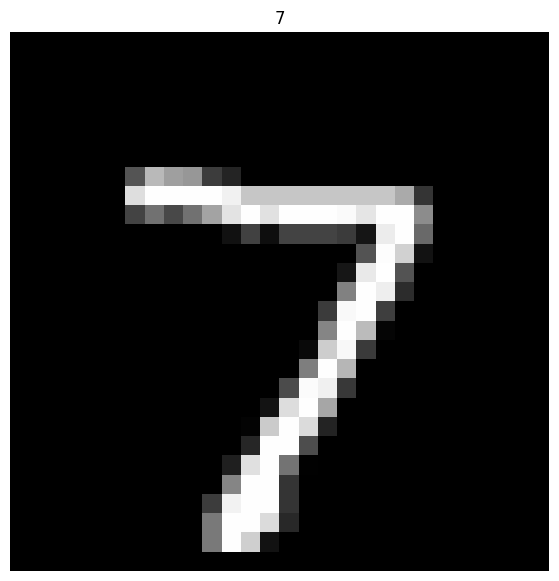

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.imshow(X[0].squeeze().numpy(), cmap='gray')
plt.axis(False)
plt.title(y[0].item())

In [18]:
import pandas as pd
logits = torch.softmax(model_load_v5(X), dim = 1)
predictions = logits.argmax(1).numpy()

In [19]:
pd.DataFrame({"PRED" : predictions, "TRUTH":y.numpy()})

,PRED,TRUTH
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
...,...,...
59,5,5
60,7,7
61,8,8
62,5,9
